# Structure detection


This notebook serves as a sandbox for structure detection of 3D microscopy images.

---

## 0. Environmental setup

In [1]:
import numpy as np
import cv2
import tifffile
import matplotlib.pyplot as plt
import sys
import random
from skimage import exposure, filters, feature, restoration, measure, morphology, color, segmentation
from scipy import ndimage as ndi
from numpy import ma
import copy
import morphsnakes as ms
from typing import List

sys.path.append('..')

from src.utils.io import get_file_list

np.random.seed(1234)
random.seed(1234)

In [2]:
def show_plane(ax, plane, cmap="gray", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.axis("off")

    if title:
        ax.set_title(title)

        
def explore_slices(data, cmap="gray"):
    from ipywidgets import interact
    N = len(data)

    @interact(plane=(0, N - 1))
    def display_slice(plane=34):
        fig, ax = plt.subplots(figsize=(20, 5))

        show_plane(ax, data[plane], title="Plane {}".format(plane), cmap=cmap)

        plt.show()

    return display_slice

def explore_slices_2_samples(data, cmap="gray"):
    from ipywidgets import interact
    N = len(data[0])

    @interact(plane=(0, N - 1))
    def display_slice(plane=34):
        fig, ax = plt.subplots(figsize=(20, 5), nrows=1, ncols=2)

        show_plane(ax[0], data[0][plane], title="Plane {}".format(plane), cmap=cmap)
        show_plane(ax[1], data[1][plane], title='Plane {}'.format(plane), cmap=cmap)
        plt.show()

    return display_slice


In [3]:
def get_nuclei_masks(cells, smoothing=1, fill_holes_layer_wise=True):
    cell_masks = []
    for i in range(len(cells)):
        cell_mask = segmentation.morphological_chan_vese(filters.median(cells[i]), smoothing=smoothing, iterations=300, 
                                                         init_level_set='circle')
        cell_mask = ndi.binary_fill_holes(cell_mask)
        if fill_holes_layer_wise:
            for j in range(len(cell_mask)):
                cell_mask[j] = ndi.binary_fill_holes(cell_mask[j])
        cell_masks.append(np.array(cell_mask))
    return cell_masks

In [4]:
def remove_noise_layers(cells, masks):
    masked_cells = []
    for i in range(len(cells)):
        masked_cell = copy.deepcopy(cells[i])
        for j in range(len(cell_masks[i])):
            if not cell_masks[i][j].astype(bool).any():
                masked_cell[j] = np.zeros_like(masked_cell[j])
        masked_cells.append(masked_cell)
    return masked_cells

In [5]:
def denoise_cells_bilateral(cells, sigma=15, median_filter_size=0):
    denoised_cells = []
    for i in range(len(cells)):
        denoised_cell = []
        for j in range(len(cells[i])):
            denoised_cell.append(restoration.denoise_bilateral(cells[i][j], sigma_spatial=sigma, 
                                                               multichannel=False))
        if median_filter_size>0:
            denoised_cell = ndi.median_filter(np.array(denoised_cell), median_filter_size)
        denoised_cells.append(np.array(denoised_cell))
    return denoised_cells

In [6]:
def filter_noise_layers(cells, sigma=2):
    filtered_cells = []
    for i in range(len(cells)):
        cell= []
        for j in range(len(cells[i])):
            edges = feature.canny(cells[i][j], sigma)
            if np.any(edges):
                cell.append(cells[i][j])
            else:
                cell.append(np.zeros(cells[i][j].shape))
        filtered_cells.append(np.array(cell))
    return filtered_cells

In [7]:
def rescale_intensities(cell_imgs, qs=None, out_range=None):
    if qs is None:
        qs=[0.5, 99.5]
    if out_range is None:
        out_range = np.float32
    rescaled_cell_imgs = []
    
    for i in range(len(cell_imgs)):
        vmin, vmax = np.percentile(cell_imgs[i], q=qs)
        rescaled_cell_imgs.append(exposure.rescale_intensity(cell_imgs[i], in_range=(vmin, vmax), 
                                                             out_range=out_range))

    return rescaled_cell_imgs

In [8]:
def color_3d_cells(cell_masks, cells):
    colored_cells = []
    for i in range(len(cell_masks)):
        cell_mask = cell_masks[i]
        cell_mask = cell_mask.astype(int)
        cell = cells[i]
        cell = np.uint8(cell * 255/cell.max())
        colored_cell = []
        for j in range(len(cell_mask)):
            colored_cell.append(color.label2rgb(cell_mask[j], cell[j], bg_label=0))
        colored_cells.append(np.array(colored_cell))
    return colored_cells

In [9]:
def get_hc_ec_structure_maps_by_thresholding(cells, cell_masks, k=0.6):
    structure_dicts = []
    for i in range(len(cells)):
        cell_img = copy.deepcopy(cells[i])
        #cell_img = filters.median(cell_img)
        masked_cell = ma.masked_array(cell_img, ~cell_masks[i])
        threshold = masked_cell.min() + k * (masked_cell.max() - masked_cell.min())
        hc_mask = masked_cell > threshold
        ec_mask = masked_cell <= threshold
        structure_dict = {'cell_img':cells[i], 'masked_cell':masked_cell, 'hc_mask' : hc_mask, 
                          'ec_mask' : ec_mask}
        structure_dicts.append(structure_dict)
    return structure_dicts

In [10]:
def get_labeled_cells_for_hc_ec_structures(stucture_dicts):
    labeled_cells = []
    for i in range(len(structure_dicts)):
        labeled_cell = np.zeros_like(structure_dicts[i]['cell_img'])
        cell_mask = ~ma.getmask(structure_dicts[i]['masked_cell'])
        hc_mask = np.array(structure_dicts[i]['hc_mask'])
        labeled_cell[cell_mask]= 1
        labeled_cell[hc_mask] = 2
        labeled_cells.append(np.uint16(labeled_cell))
    return labeled_cells

In [11]:
def plot_3d_images_as_map(
    images: List[np.ndarray],
    n_images_per_slide: int = 20,
    max_depth: int = 23,
):
    depth = max_depth
    figures = []
    fig = None
    for i in range(len(images)):
        idx = i % n_images_per_slide
        if idx == 0:
            fig, ax = plt.subplots(
                nrows=n_images_per_slide,
                ncols=depth,
                figsize=[12.8, 10.0],
                gridspec_kw={"wspace": 0.0, "hspace": 0.0},
            )

        for j in range(depth):
            if j < np.squeeze(images[i]).shape[0]:
                img = np.squeeze(images[i])
                #if len(img.shape) == 4:
                #    img = img[j,0,:,:]
                #else:
                #    img = img[j,:,:]
                img = img[j]
                img = cv2.resize(img, dsize=(64, 64))
                if img.max() > 0 :
                    img = img / img.max()
            else:
                img = np.zeros([64, 64])
            ax[idx, j].imshow(
                img, interpolation="nearest", cmap="magma",
            )
            ax[idx, j].axis("off")
            #ax[idx, j].set_aspect("auto")
        if idx == n_images_per_slide - 1:
            figures.append(fig)
            fig.subplots_adjust(hspace=0.0, wspace=0.0)
            plt.subplots_adjust(hspace=0.0, wspace=0.0)
            plt.show()

---
## 1. Read in data

In [12]:
root_dir = '../data/tcell_project/filtered/selected_slices_ar_08_area25_50_16bit'
file_list = get_file_list(root_dir)

healthy_cell_ids = list(range(20))
healthy_cells = []

for i in range(len(healthy_cell_ids)):
    healthy_cells.append(np.squeeze(tifffile.imread(file_list[healthy_cell_ids[i]])))

In [13]:
explore_slices_2_samples(healthy_cells[:2])

interactive(children=(IntSlider(value=20, description='plane', max=20), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices_2_samples.<locals>.display_slice(plane=34)>

---

## 2. Noise reduction

The microscopy images are subject to different types of noise including Gaussian and salt-pepper noise. To denoise the images different techniques can be applied. Importantly, the SNR is especially high for very low and high levels of depth of the image as defined by the PSF function of confocal microscopies.

However, before we will remove any signal from those layers that show no clear structure of an object (the nucleus). To this end, we will obtain the nuclear masks for each image using the Chan-Vese algorithm, and set any value outside the mask manually to zero.

In [14]:
cell_masks = get_nuclei_masks(healthy_cells, smoothing=1)

/usr/share/miniconda3/envs/nt/lib/python3.8/site-packages/skimage/segmentation/morphsnakes.py:106: FutureWarning: circle_level_set is deprecated in favor of disk_level_set.circle_level_set will be removed in version 0.19
  res = circle_level_set(image_shape)


In [15]:
explore_slices(exposure.adjust_gamma(filters.median(healthy_cells[0]), 2))

interactive(children=(IntSlider(value=20, description='plane', max=20), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices.<locals>.display_slice(plane=34)>

In [16]:
explore_slices_2_samples([cell_masks[0], cell_masks[1]])

interactive(children=(IntSlider(value=20, description='plane', max=20), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices_2_samples.<locals>.display_slice(plane=34)>

In [17]:
masked_cells = remove_noise_layers(healthy_cells, cell_masks)

In [18]:
filtered_cells = denoise_cells_bilateral(masked_cells, median_filter_size=0)

In [19]:
explore_slices_2_samples([healthy_cells[2], filtered_cells[2]], cmap='seismic')

interactive(children=(IntSlider(value=20, description='plane', max=20), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices_2_samples.<locals>.display_slice(plane=34)>

While the results look promising, we still face the issue that if there is not object in the picture (i.e. for the first couple and the last layers typically) the SNR << 1, which means we basically look at random noise. A simple method would be to remove the first 2 and final 2 layers, respectively segment the individual images additionally to find the borders of the nuclei in the z-dimension.

The latter approach seems to be more sophisticated and promising is however at the time being subject to future work.

---

## 3. Exposure correction on nuclei mask

After reading in the data, we will adjust the contrasts of the images to facilitate the consecutive structure detection. 

Let us inspect the effect of the intensity rescaling.

In [20]:
rescaled_cells = rescale_intensities(filtered_cells)
explore_slices_2_samples([masked_cells[0], rescaled_cells[0]], cmap='seismic')

interactive(children=(IntSlider(value=20, description='plane', max=20), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices_2_samples.<locals>.display_slice(plane=34)>

---

## 4. Chromatin structure detection

We will now use the contrast enhanced images and try to identify heterochromatal and euchromatal structures. We know that heterochromatin is visible in the image space by regions of higher intensities as the more densely packed DNA reflects more light. Euchromatin on the opposite marks areas of loosely packed DNA, i.e. those areas in the image space for DAPI stained nuclei, where we see darker patterns.





### 4.1. Thresholding
A straight forward approach is simply applying a threshold to bin the image into background, heterochromatin and euchromatin areas.


In [21]:
colored_cell_masks = color_3d_cells(cell_masks, rescaled_cells)

In [22]:
explore_slices_2_samples(colored_cell_masks)

interactive(children=(IntSlider(value=20, description='plane', max=20), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices_2_samples.<locals>.display_slice(plane=34)>

In [23]:
structure_dicts = get_hc_ec_structure_maps_by_thresholding(rescaled_cells, cell_masks)

In [24]:
explore_slices_2_samples([structure_dicts[0]['masked_cell'], structure_dicts[0]['hc_mask']])

interactive(children=(IntSlider(value=20, description='plane', max=20), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices_2_samples.<locals>.display_slice(plane=34)>

In [25]:
labeled_cells = get_labeled_cells_for_hc_ec_structures(structure_dicts)

In [26]:
color_labeled_cells = color_3d_cells(labeled_cells, rescaled_cells)

In [27]:
explore_slices_2_samples([color_labeled_cells[5], color_labeled_cells[8]])

interactive(children=(IntSlider(value=20, description='plane', max=20), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices_2_samples.<locals>.display_slice(plane=34)>

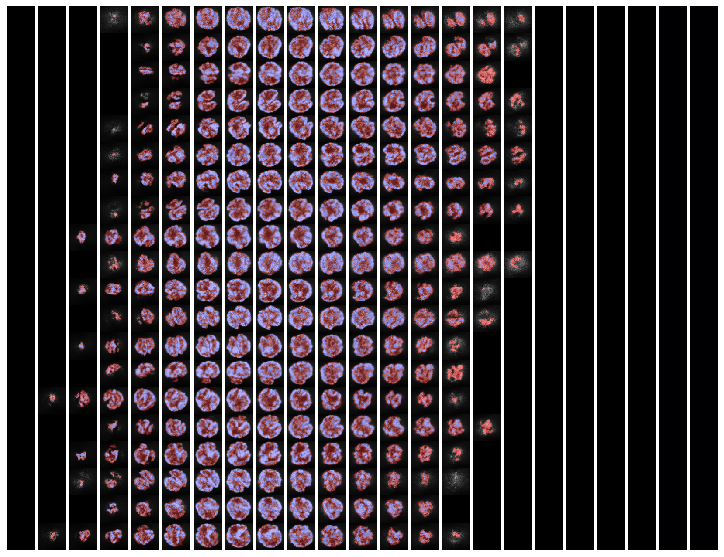

In [28]:
plot_3d_images_as_map(color_labeled_cells, n_images_per_slide=20)

The above shows the result of the threshold-based segmentation of heterochromatin (blue) and euchormatin(red). Note that the segmentation does not distinguish between other potential structures that could cause the intensity differences.

---

## 5. Chromosome border detection

Going one step further we would like to explore if it is possible to derive borders of chromosomes from the DAPI images for the individual cells. While labeled images can be obtained experimentally using FISH, we here focus on approaches that only use the segmented nuclei DAPI images. We exploit the fact that, we now that more transcription happens along the overlap of chromosomes in space and in the image this will be shown as areas of lower intensity. The idea is that using the images, we might find tube-like objects that could represent the centromeres of a chromosome. If we can follow the direction of the surface, we might be able to associate areas of lower intensity to potential overlaps of chromosomes.

As a first step however, we aim to segment the intranuclear structure into different segments. We are particurly interested in the heterochromatin structures. After segmenting those, we can try to analyze the individual detected heterochromatin formations and see if those form what could be centromeres or telomeres of some chromosomes.

However, it is important that the quality of the images (with respect to the resolution and the staining) prohibits any sophisticated assessment of how well we are doing. We lack both ground truth information about the position of certain chromosomes in 3D and and images that have a higher SNR.

#### Nuclei segmentation

In [29]:
import visvis as vv
from skimage import util
verts, faces, normals, values = measure.marching_cubes(rescaled_cells[0], allow_degenerate=False)
vv.mesh(np.fliplr(verts), faces, normals, values)
vv.use().Run()

#### Euchromatin surface structures